# 機械学習帳 確認問題(2.10)

[機械学習帳の単回帰の確認問題(2.10)を解きます](https://chokkan.github.io/mlnote/regression/02mra.html#id17)。
計算結果を確認するため、2.9で紹介されているNumpyの`polifit`とscikit-learnの`LinearRegression`を使用します。

## 講義内容の復習

![chapter2-1.PNG](./images/chapter2/chapter2-1.PNG)

## 0. データの準備

演習用のデータを定義します。

In [1]:
import numpy as np


D = np.array([[1, 3], [3, 6], [6, 5], [8, 7]])
X = D[:, 0]
Y = D[:, 1]

In [2]:
np.hstack([np.ones(len(D)).reshape((-1, 1)), D[:,:-1]])

array([[1., 1.],
       [1., 3.],
       [1., 6.],
       [1., 8.]])

## 1. 行列による1次関数のパラメータ推定

重回帰のクラス`MultipleRegression`を定義します。`train`でパラメーターを求め、`predict`で目的変数を推定します。
パラメーターの計算式は公式の通りです。[Python 3.5から、`@`で行列積を計算できるようになった](https://docs.python.org/ja/3/library/operator.html#operator.__matmul__)ため、利用しています。切片を求めるため、$X$に定数を加えられるか`add_constant`で選択できるようにしています。

In [3]:
class MultipleRegression():
    
    def __init__(self, add_constant=True):
        self.w = None
        self.add_constant = add_constant
    
    def train(self, examples):
        x = examples[:,:-1]
        if self.add_constant:
            x = np.hstack([np.ones(len(x)).reshape((-1, 1)), x])
        y = examples[:,-1].reshape((-1, 1))
        self.w = np.linalg.inv(x.T @ x) @ x.T @ y
        return self
    
    def predict(self, x):
        if len(x.shape) == 1:
            x = x.reshape((-1, 1))
        if self.add_constant:
            x = np.hstack([np.ones(len(x)).reshape((-1, 1)), x])
        return (x @ self.w).flatten()


In [4]:
model = MultipleRegression().train(D)
model.w

array([[3.31034483],
       [0.43103448]])

`numpy.polynomial.Polynomial`により検算を行う。[`np.polyfit`はNumpy 1.4以降から非推奨となった](https://numpy.org/doc/stable/reference/routines.polynomials.html)。`Polynomial.fit`は`domain`/`window`にスケールされた値を返すので、スケールされる前の値を取得するには`covert`を行う必要がある。

In [5]:
from numpy.polynomial import Polynomial


w = Polynomial.fit(X, Y, deg=1).convert()
np.testing.assert_allclose(model.w.flatten(), w.coef)

<AxesSubplot:xlabel='x', ylabel='y'>

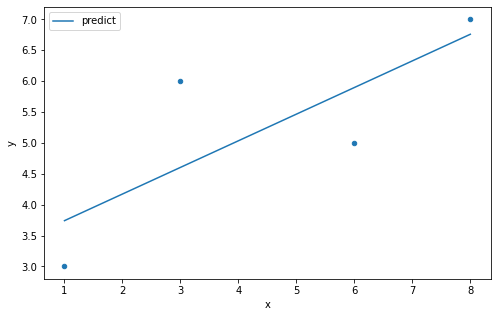

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8,5))
data = pd.DataFrame({"x": X, "y": Y, "predict": model.predict(X)})
data.plot.scatter(x="x", y="y", grid=True, ax=ax)
data.plot.line(x="x", y="predict", zorder=-1, ax=ax)

## 2.2次関数による重回帰

2次の値`X**2`を説明変数に入れてパラメーターの計算を行います。

In [7]:
X_squred_examples = np.vstack([X, X**2, Y]).T
X_squred_examples

array([[ 1,  1,  3],
       [ 3,  9,  6],
       [ 6, 36,  5],
       [ 8, 64,  7]])

In [8]:
model2 = MultipleRegression().train(X_squred_examples)
model2.w

array([[ 2.66034483],
       [ 0.88103448],
       [-0.05      ]])

scikit-learnの`LinearRegression`を用いて検算します。`PolynomialFeatures`を使用すると指定した次数の特徴を生成してくれるので便利です。

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X.reshape(-1, 1), Y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [10]:
w2 = np.hstack([np.array([pipeline[-1].intercept_]), pipeline[-1].coef_[1:]])

In [11]:
np.testing.assert_allclose(model2.w.flatten(), w2)

## 3. 回帰曲線の描画

回帰で求められた曲線を描画します。

<AxesSubplot:xlabel='x', ylabel='y'>

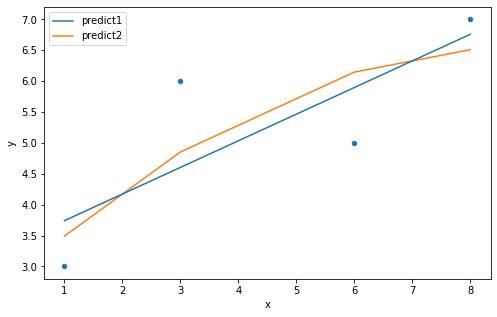

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
data = pd.DataFrame({"x": X, "y": Y, "predict1": model.predict(X), "predict2": model2.predict(X_squred_examples[:, :-1])})
data.plot.scatter(x="x", y="y", grid=True, ax=ax)
data.plot.line(x="x", y="predict1", zorder=0, ax=ax)
data.plot.line(x="x", y="predict2", zorder=-1, ax=ax)

## 4.決定係数

単回帰の時と計算は同じです。

In [13]:
r2 = 1 - np.var(data["y"] - data["predict2"]) / np.var(data["y"])
r2

0.6443349753694578

In [14]:
from sklearn.metrics import r2_score


r2_2 = r2_score(data["y"], data["predict2"])

In [15]:
np.testing.assert_almost_equal(r2, r2_2)

## 5. 3次関数による重回帰

2次と同じように計算します。

In [16]:
X_cubed_examples = np.vstack([X, X**2, X**3, Y]).T
X_cubed_examples

array([[  1,   1,   1,   3],
       [  3,   9,  27,   6],
       [  6,  36, 216,   5],
       [  8,  64, 512,   7]])

In [17]:
model3 = MultipleRegression().train(X_cubed_examples)
model3.w

array([[-1.22857143],
       [ 5.40952381],
       [-1.27142857],
       [ 0.09047619]])

In [18]:
pipeline = make_pipeline(PolynomialFeatures(3), LinearRegression())
pipeline.fit(X.reshape(-1, 1), Y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [19]:
w3 = np.hstack([np.array([pipeline[-1].intercept_]), pipeline[-1].coef_[1:]])
w3

array([-1.22857143,  5.40952381, -1.27142857,  0.09047619])

In [20]:
np.testing.assert_allclose(model3.w.flatten(), w3)

## 6.回帰曲線の描画

<AxesSubplot:xlabel='x', ylabel='y'>

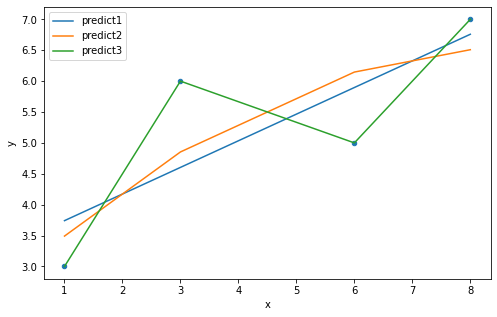

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
data = pd.DataFrame({
    "x": X,
    "y": Y,
    "predict1": model.predict(X),
    "predict2": model2.predict(X_squred_examples[:, :-1]),
    "predict3": model3.predict(X_cubed_examples[:, :-1]),
})
data.plot.scatter(x="x", y="y", grid=True, ax=ax)
data.plot.line(x="x", y="predict1", zorder=0, ax=ax)
data.plot.line(x="x", y="predict2", zorder=1, ax=ax)
data.plot.line(x="x", y="predict3", zorder=2, ax=ax)

## 7. 決定係数


In [22]:
r2 = 1 - np.var(data["y"] - data["predict3"]) / np.var(data["y"])
r2

1.0

In [23]:
r2_3 = r2_score(data["y"], data["predict3"])

In [24]:
np.testing.assert_almost_equal(r2, r2_3)